Imports and loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
presence = pd.read_csv('presence_2025-05-04_21-00.csv')
population = pd.read_csv('estat_demo_pjangroup$defaultview_filtered_en.csv')

presence.head(2)

,Judet,UAT,Localitate,Siruta,Nr sectie de votare,Nume sectie de votare,Mediu,Înscriși pe liste permanente,LP,LS,...,Femei 111,Femei 112,Femei 113,Femei 114,Femei 115,Femei 116,Femei 117,Femei 118,Femei 119,Femei 120
0,AB,MUNICIPIUL ALBA IULIA,ALBA IULIA,1017,1,CENTRUL DE ZI PENTRU PERSOANE VÂRSTNICE,U,1777,887,65,...,0,0,0,0,0,0,0,0,0,0
1,AB,MUNICIPIUL ALBA IULIA,ALBA IULIA,1017,2,ŞCOALA GIMNAZIALĂ „VASILE GOLDIŞ”,U,985,501,90,...,0,0,0,0,0,0,0,0,0,0


We'll separate votes into age groups

In [68]:
age_groups = ["Barbati 18-24","Barbati 25-34","Barbati 35-44","Barbati 45-64","Barbati 65+","Femei 18-24","Femei 25-34","Femei 35-44","Femei 45-64","Femei 65+"]

age_group_count = presence[age_groups].sum()
age_group_count

Barbati 18-24     367862
Barbati 25-34     603845
Barbati 35-44     909214
Barbati 45-64    1870019
Barbati 65+       952283
Femei 18-24       373845
Femei 25-34       611195
Femei 35-44       869933
Femei 45-64      1858511
Femei 65+        1155033
dtype: int64

Now let's get the population in Romania for these age groups

In [69]:
population.head(2)

,DATAFLOW,LAST UPDATE,freq,unit,sex,age,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:DEMO_PJANGROUP$DEFAULTVIEW(1.0),24/04/25 23:00:00,Annual,Number,Females,Total,Andorra,2019,37388.0,NaN,NaN
1,ESTAT:DEMO_PJANGROUP$DEFAULTVIEW(1.0),24/04/25 23:00:00,Annual,Number,Females,Total,Albania,2015,1424597.0,NaN,NaN


In [123]:
def map_age_range_to_group(age_range):
    if "Less than" in age_range or " 0 to" in age_range or " 5 to" in age_range or "10 to" in age_range:
        return None  # Under 18, not included
    elif "20 to 24" in age_range or "15 to 19" in age_range:
        return "18-24"
    elif "25 to 29" in age_range or "30 to 34" in age_range:
        return "25-34"
    elif "35 to 39" in age_range or "40 to 44" in age_range:
        return "35-44"
    elif "45 to 49" in age_range or "50 to 54" in age_range or "55 to 59" in age_range or "60 to 64" in age_range:
        return "45-64"
    elif "65" in age_range or "70" in age_range or "75" in age_range or "80" in age_range or "85" in age_range or "90" in age_range:
        return "65+"
    else:
        return None

In [134]:
# we'll take 2024 since it's the most recent year we have in the dataset
# and ['geo'] == 'Romania' since we re only looking for the population in Romania

population_romania = population[(population['geo'] == 'Romania') & (population['TIME_PERIOD'] == 2024)]
population_romania['Mapped Group'] = population_romania['age'].apply(map_age_range_to_group)
grouped_population = population_romania.groupby(['Mapped Group', 'sex'])['OBS_VALUE'].sum()

# these are minors
grouped_population.loc[('18-24', 'Females')] -= 300_000
grouped_population.loc[('18-24', 'Males')] -= 300_000
grouped_population.loc[('18-24', 'Total')] -= 600_000
print(grouped_population)

Mapped Group  sex    
18-24         Females     709772.0
              Males       771649.0
              Total      1481421.0
25-34         Females    1010859.0
              Males      1081235.0
              Total      2092094.0
35-44         Females    1292161.0
              Males      1376820.0
              Total      2668981.0
45-64         Females    2712102.0
              Males      2662808.0
              Total      5374910.0
65+           Females    3823203.0
              Males      2328425.0
              Total      6151628.0
Name: OBS_VALUE, dtype: float64


C:\Users\Tudor\AppData\Local\Temp\ipykernel_10928\2207976281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_romania['Mapped Group'] = population_romania['age'].apply(map_age_range_to_group)


Let's get the voting presence looking like this

In [135]:
def map_sex(age_text):
    if 'Barbati' in age_text:
        return 'Males'
    elif 'Femei' in age_text:
        return 'Females'
    return None

In [136]:
# we re adding the sex columns

age_group_count_df = age_group_count.reset_index().rename(columns={'index':'age', 0:'OBS_VALUE'})
age_group_count_df['sex'] = age_group_count_df['age'].apply(map_sex)
age_group_count_df

,age,OBS_VALUE,sex
0,Barbati 18-24,367862,Males
1,Barbati 25-34,603845,Males
2,Barbati 35-44,909214,Males
3,Barbati 45-64,1870019,Males
4,Barbati 65+,952283,Males
5,Femei 18-24,373845,Females
6,Femei 25-34,611195,Females
7,Femei 35-44,869933,Females
8,Femei 45-64,1858511,Females
9,Femei 65+,1155033,Females


In [137]:
def map_age(age_text):
    return age_text.replace('Barbati ', '').replace('Femei ', '')

In [138]:
# let's fix the age column now:
age_group_count_df['age'] = age_group_count_df['age'].apply(map_age)
age_group_count_df

,age,OBS_VALUE,sex
0,18-24,367862,Males
1,25-34,603845,Males
2,35-44,909214,Males
3,45-64,1870019,Males
4,65+,952283,Males
5,18-24,373845,Females
6,25-34,611195,Females
7,35-44,869933,Females
8,45-64,1858511,Females
9,65+,1155033,Females


Now we can plot procentages

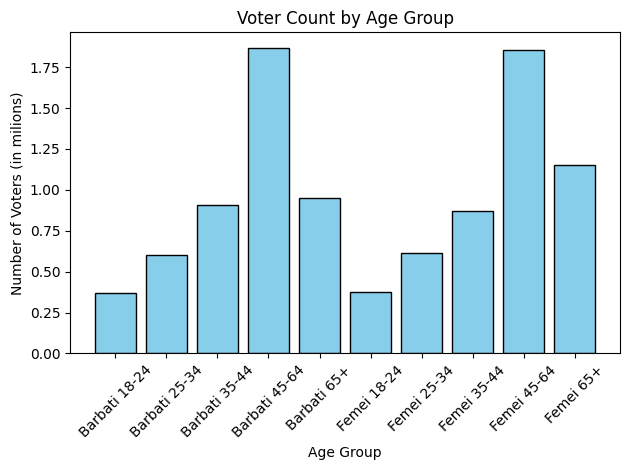

In [143]:
import matplotlib.pyplot as plt

# this will be the basic plot with the number of votes

plt.bar(x=age_group_count.index, height=age_group_count.values / 1000_000, color='skyblue', edgecolor='black')
plt.title('Voter Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Voters (in milions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

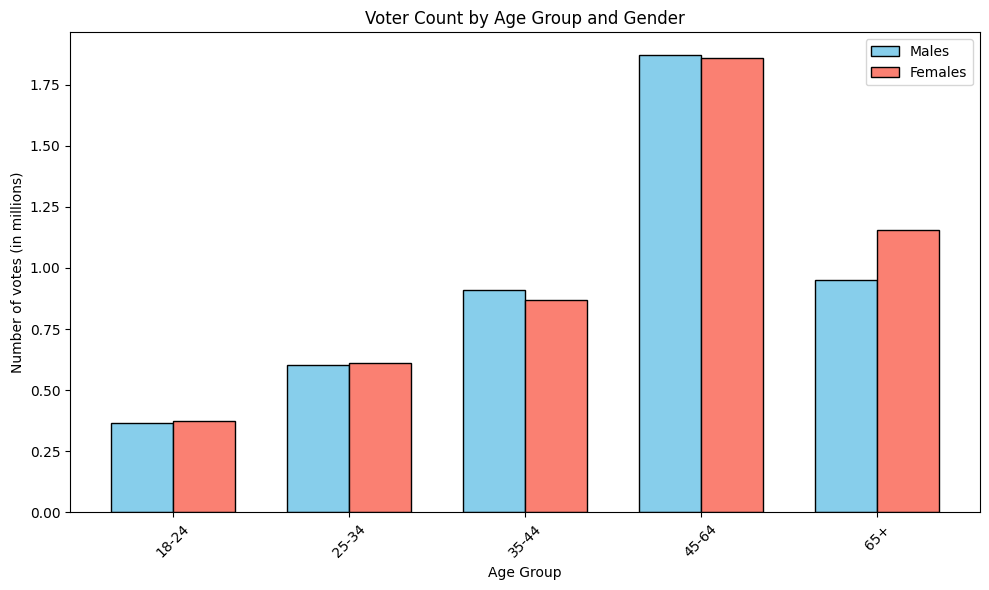

In [145]:
# now with the data frame and we ll also color the ganders

import matplotlib.pyplot as plt

df_vot = age_group_count_df.reset_index()
votes_pivot = df_vot.pivot(index='age', columns='sex', values='OBS_VALUE') / 1_000_000  # in thousands

age_groups = votes_pivot.index
x = np.arange(len(age_groups))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, votes_pivot['Males'], width, label='Males', color='skyblue', edgecolor='black')
ax.bar(x + width/2, votes_pivot['Females'], width, label='Females', color='salmon', edgecolor='black')

ax.set_title('Voter Count by Age Group and Gender')
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of votes (in millions)')
ax.set_xticks(x)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


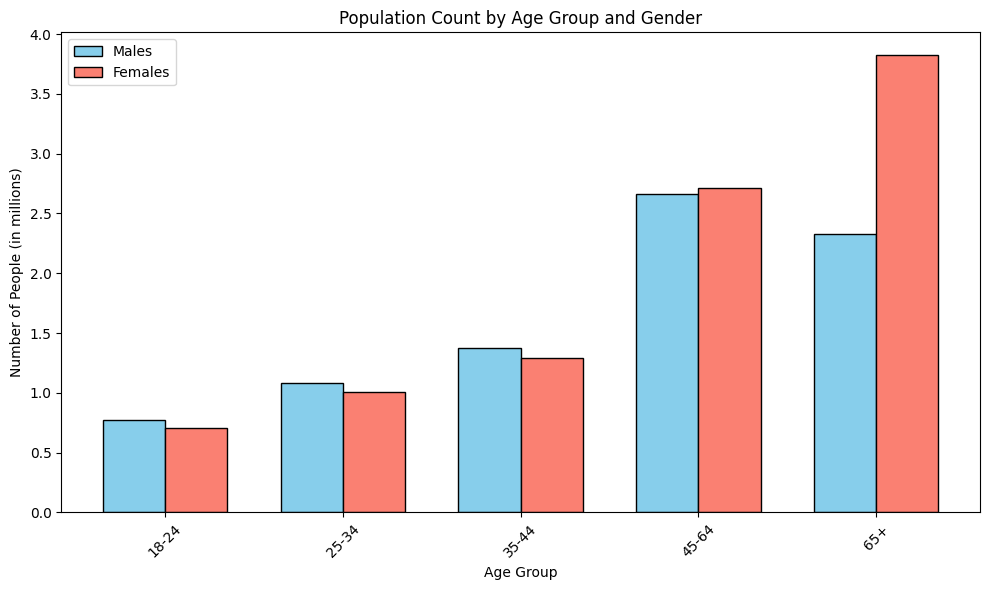

In [146]:
import matplotlib.pyplot as plt

# here we'll plot the population for age groups

df_pop = grouped_population.reset_index()
pivot_df = df_pop.pivot(index='Mapped Group', columns='sex', values='OBS_VALUE') / 1_000_000  # in millions

age_groups = pivot_df.index
x = np.arange(len(age_groups))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, pivot_df['Males'], width, label='Males', color='skyblue', edgecolor='black')
ax.bar(x + width/2, pivot_df['Females'], width, label='Females', color='salmon', edgecolor='black')

ax.set_title('Population Count by Age Group and Gender')
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of People (in millions)')
ax.set_xticks(x)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


lovely now let's get to the most important part and see the procentage of how many paople vor for each age chategory

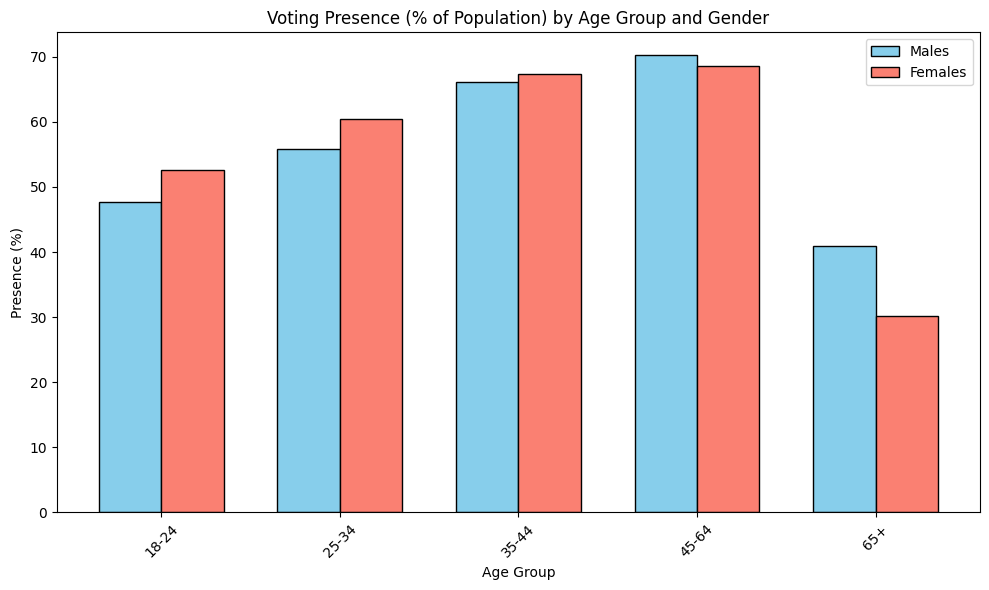

In [151]:
votes_pivot = df_vot.pivot(index='age', columns='sex', values='OBS_VALUE')
pivot_df = df_pop.pivot(index='Mapped Group', columns='sex', values='OBS_VALUE')

percentage_df = (votes_pivot / pivot_df) * 100
x = np.arange(len(percentage_df))

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, percentage_df['Males'], width, label='Males', color='skyblue', edgecolor='black')
ax.bar(x + width/2, percentage_df['Females'], width, label='Females', color='salmon', edgecolor='black')

ax.set_title('Voting Presence (% of Population) by Age Group and Gender')
ax.set_xlabel('Age Group')
ax.set_ylabel('Presence (%)')
ax.set_xticks(x)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


Now we can see that the 18-24 and 25-34 aren't as bad as the raw number makes it seem

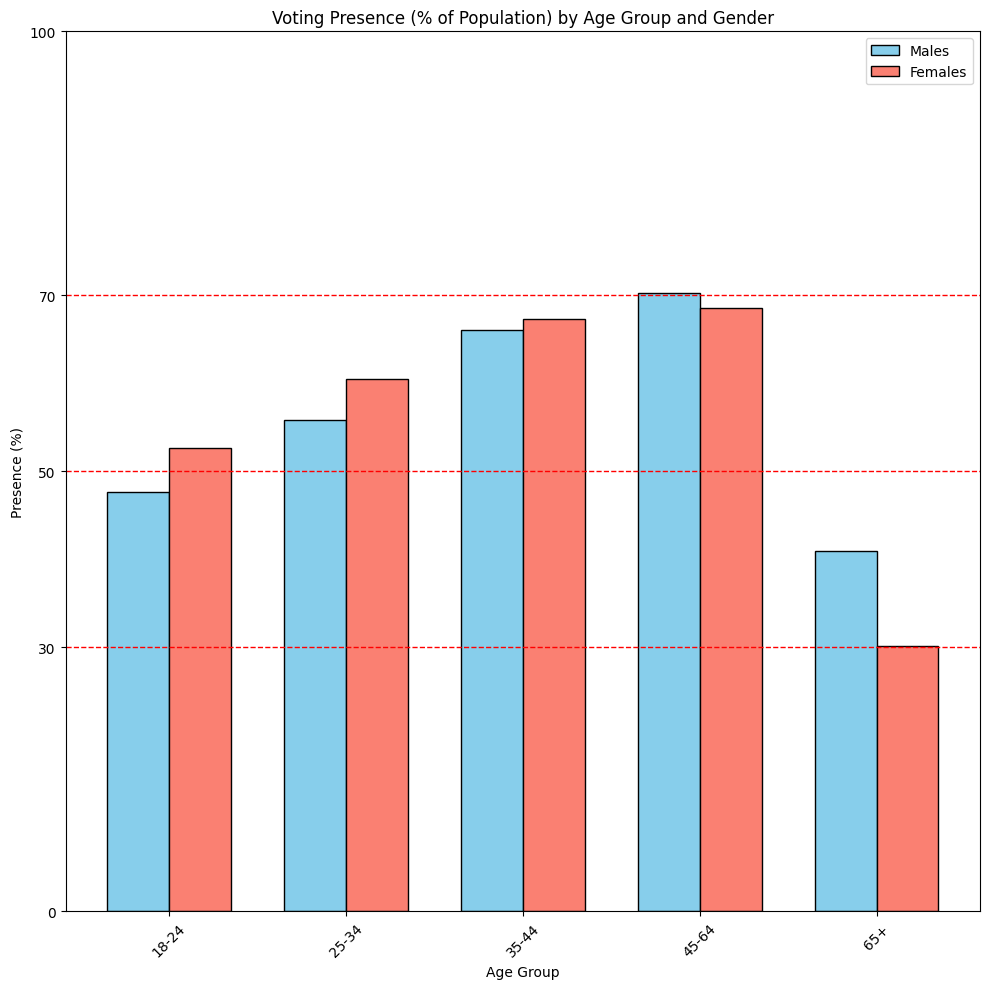

In [171]:
# same plot but with max y value 100
votes_pivot = df_vot.pivot(index='age', columns='sex', values='OBS_VALUE')
pivot_df = df_pop.pivot(index='Mapped Group', columns='sex', values='OBS_VALUE')

percentage_df = (votes_pivot / pivot_df) * 100
x = np.arange(len(percentage_df))

fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(x - width/2, percentage_df['Males'], width, label='Males', color='skyblue', edgecolor='black')
ax.bar(x + width/2, percentage_df['Females'], width, label='Females', color='salmon', edgecolor='black')

ax.axhline(70, color='red', linestyle='--', linewidth=1)
ax.axhline(50, color='red', linestyle='--', linewidth=1)
ax.axhline(30, color='red', linestyle='--', linewidth=1)

ax.set_title('Voting Presence (% of Population) by Age Group and Gender')
ax.set_xlabel('Age Group')
ax.set_ylabel('Presence (%)')
ax.set_xticks(x)
ax.set_xticklabels(age_groups, rotation=45)
ax.set_yticks([0, 30, 50, 70, 100])
ax.legend()
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

In [174]:
mean_per_age_group = percentage_df.mean(axis=1)
print(mean_per_age_group)

age
18-24    50.171666
25-34    58.155322
35-44    66.680566
45-64    69.376960
65+      35.554648
dtype: float64
